# MScFE 610 Econometrics (C22-S1) - Groupwork Assignment Submission 2 M5

### Impoting required libraries

In [ ]:
import warnings
from IPython.display import Image
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model,

In [ ]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 20,10

### Step 0: Selecting a data set

For gold ETF, we choose SPDR Gold Trust (GLD) and for non-US equity ETF, we choose: iShares MSCI Emerging Markets ETF (EEM). We also pull data for Grayscale Bitcoin Trust (GBTC).

### Step 1: Data Importing

We consider three time points for splitting the pulled data:

In [ ]:
Jan20 = dt.datetime(2020,1,1)
Apr20 = dt.datetime(2020,4,1)
Jul20 = dt.datetime(2020,7,1)
Oct20 = dt.datetime(2020,10,1)
Jan21 = dt.datetime(2021,1,1)

#### Gold ETF (GLD):

In [ ]:
GLD = yf.download('GLD',start = Jan20, end = Jan21,  progress = False)
GLD[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


In [ ]:
GLD = GLD['Adj Close']

#### Emerging Markets ETF (EEM):

In [ ]:
EEM = yf.download('EEM', start = Jan20, end = Jan21, progress = False)
EEM[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,33.099998,33.330002,32.619999,32.669998,31.540224,65580600
2020-04-02,33.290001,33.939999,33.200001,33.770000,32.602184,55784000
2020-04-03,33.689999,33.860001,32.950001,33.130001,31.984316,68672500
2020-04-06,34.439999,34.950001,34.299999,34.939999,33.731720,82394800
2020-04-07,36.090000,36.119999,35.049999,35.119999,33.905499,74322600


In [ ]:
EEM = EEM['Adj Close']

#### Bitcoin (BTC):

In [ ]:
GBTC = yf.download('GBTC', start = Jan20, end = Jan21, progress = False)
GBTC[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400
2020-04-07,8.070,8.15,7.61,7.660,7.660,3469900


In [ ]:
GBTC = GBTC['Adj Close']

#### Integrating the data

In [ ]:
data = pd.DataFrame({'EEM':EEM, 'GLD':GLD, 'GBTC':GBTC})
data[Apr20:Jan21].head()

,EEM,GLD,GBTC
Date,,,
2020-04-01,31.540224,149.449997,6.495
2020-04-02,32.602184,151.899994,7.720
2020-04-03,31.984316,152.649994,7.480
2020-04-06,33.731720,156.880005,7.950
2020-04-07,33.905499,156.039993,7.660


In [ ]:
data.isnull().any()

EEM     False
GLD     False
GBTC    False
dtype: bool

In [ ]:
data_Q2 = data[Apr20:Jul20]
data_Q3 = data[Jul20:Oct20]
data_Q4 = data[Oct20:Jan21]

### Step 2: Data Processing

In [ ]:
data['GLD_lr'] = np.log(data['GLD']).diff()
data['EEM_lr'] = np.log(data['EEM']).diff()
data['GBTC_lr'] = np.log(data['GBTC']).diff()
data[Apr20:Jan21].head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr
Date,,,,,,
2020-04-01,31.540224,149.449997,6.495,0.009412,-0.043720,-0.091875
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782
2020-04-03,31.984316,152.649994,7.480,0.004925,-0.019134,-0.031582
2020-04-06,33.731720,156.880005,7.950,0.027334,0.053193,0.060939
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005139,-0.037160


### Step 3: Data Summaries

In [ ]:
data['EEM_MA20'] = data['EEM'].rolling(window=20).mean()
data['GLD_MA20'] = data['GLD'].rolling(window=20).mean()
data['GBTC_MA20'] = data['GBTC'].rolling(window=20).mean()
data = data[Apr20:Jan21]
data.head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,
2020-04-01,31.540224,149.449997,6.495,0.009412,-0.043720,-0.091875,33.350867,149.164499,7.5127
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,33.003316,148.884998,7.3522
2020-04-03,31.984316,152.649994,7.480,0.004925,-0.019134,-0.031582,32.665419,148.639998,7.1972
2020-04-06,33.731720,156.880005,7.950,0.027334,0.053193,0.060939,32.547155,148.593498,7.1512
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005139,-0.037160,32.345865,148.671498,7.0712


### Step 4: Graphing

Text(0,0.5,'Price (USD)')

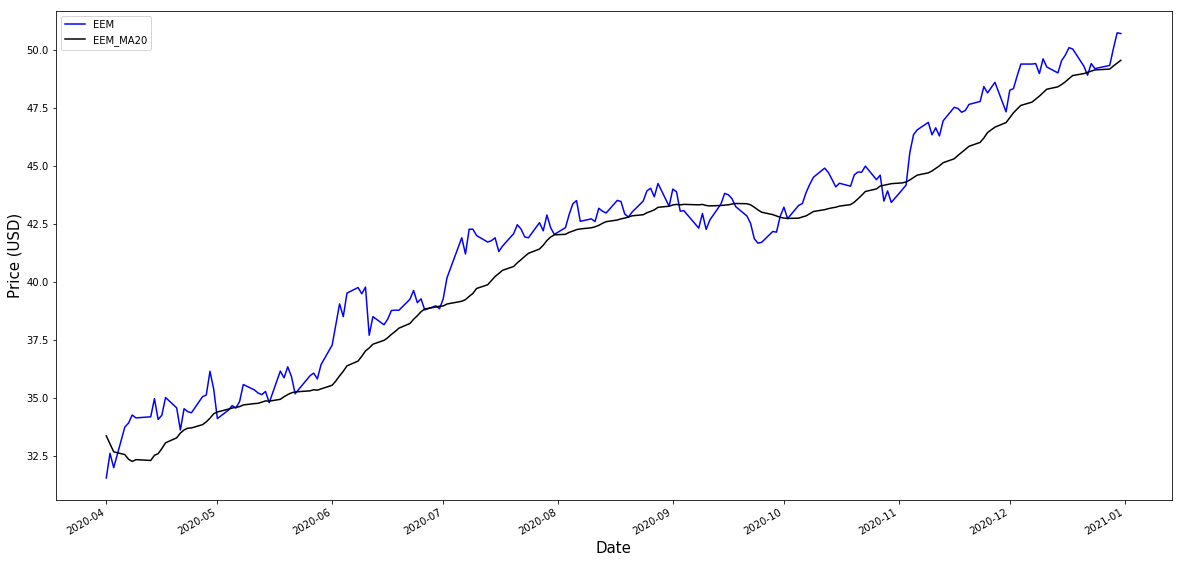

In [ ]:
ax1 = data[['EEM','EEM_MA20']].plot(color = ['blue','black'])
ax1.set_xlabel('Date', size=15)
ax1.set_ylabel('Price (USD)', size=15)

For EEM, the moving average has basically acted as up-trend support and we have only short-duration of crossing of the price and moving average.

Text(0,0.5,'Price (USD)')

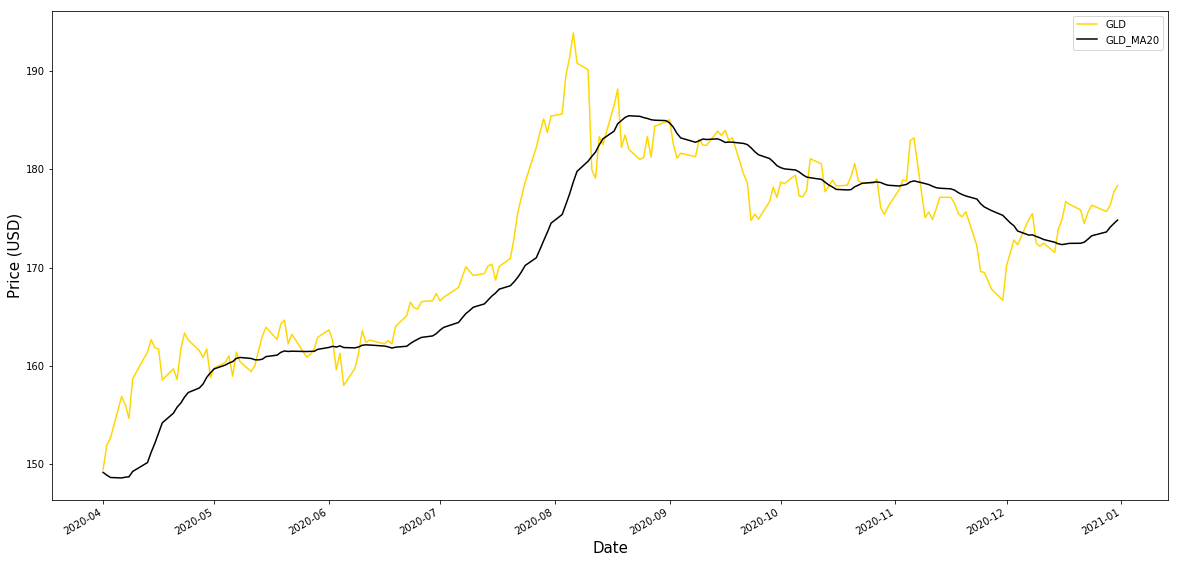

In [ ]:
ax2 = data[['GLD','GLD_MA20']].plot(color = ['gold','black'])
ax2.set_xlabel('Date', size=15)
ax2.set_ylabel('Price (USD)', size=15)

For GLD, the moving average has acted as up-trend support till mid-Aug and we have then a major crossing of the price and moving average which has lead to a sideways/down-trend price action.

Text(0,0.5,'Price (USD)')

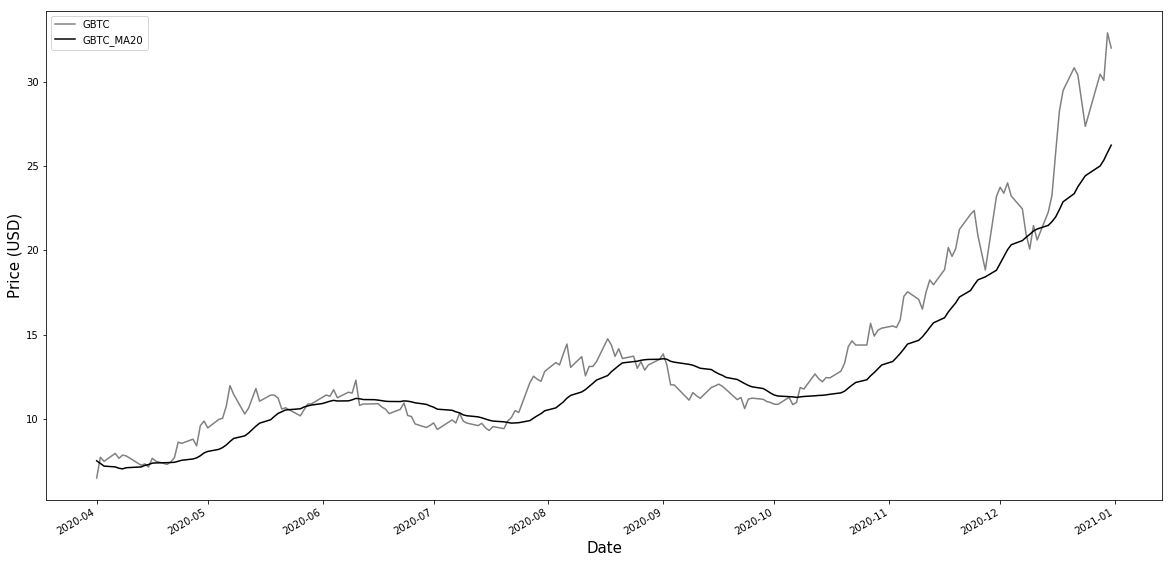

In [ ]:
ax3 = data[['GBTC','GBTC_MA20']].plot(color = ['gray','black'])
ax3.set_xlabel('Date', size=15)
ax3.set_ylabel('Price (USD)', size=15)

For GBTC, we have alternate crossing of the moving average and price till Oct which describes a sideways price action by then. However, after Oct, we have a major uptrend and no significant crossing in the continuation.

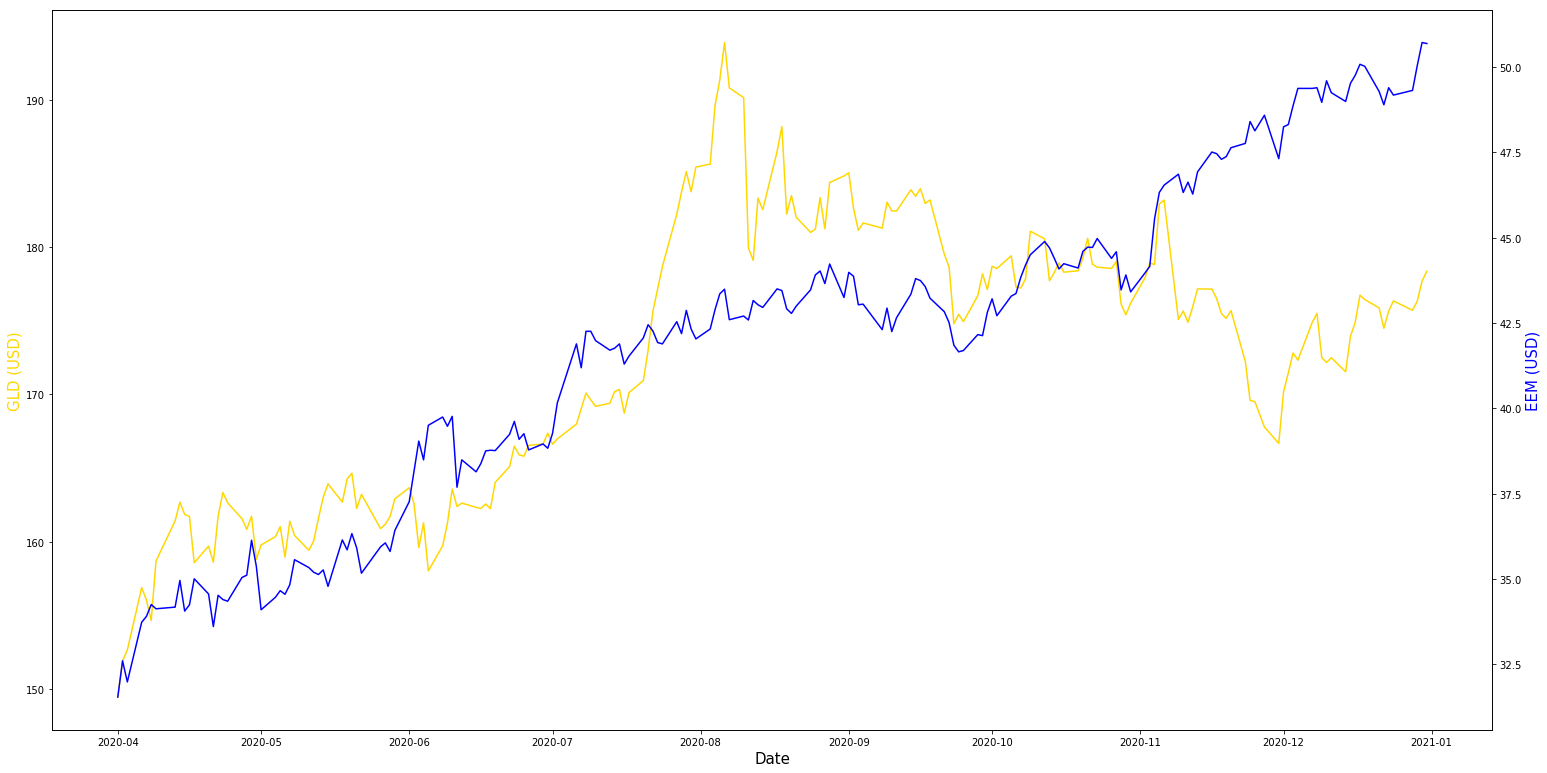

In [ ]:
fig1 = plt.figure()
ax4 = fig1.add_axes([.1,.1,1,1])
ax4.plot(data.index, data.GLD,  color='gold')
ax4.set_xlabel('Date', size = 15)
ax4.set_ylabel('GLD (USD)', size=15, color='gold')
ax4_2 = ax4.twinx()
ax4_2.plot(data.index, data.EEM, color='blue')
ax4_2.set_ylabel('EEM (USD)', size=15, color='blue')
plt.show()

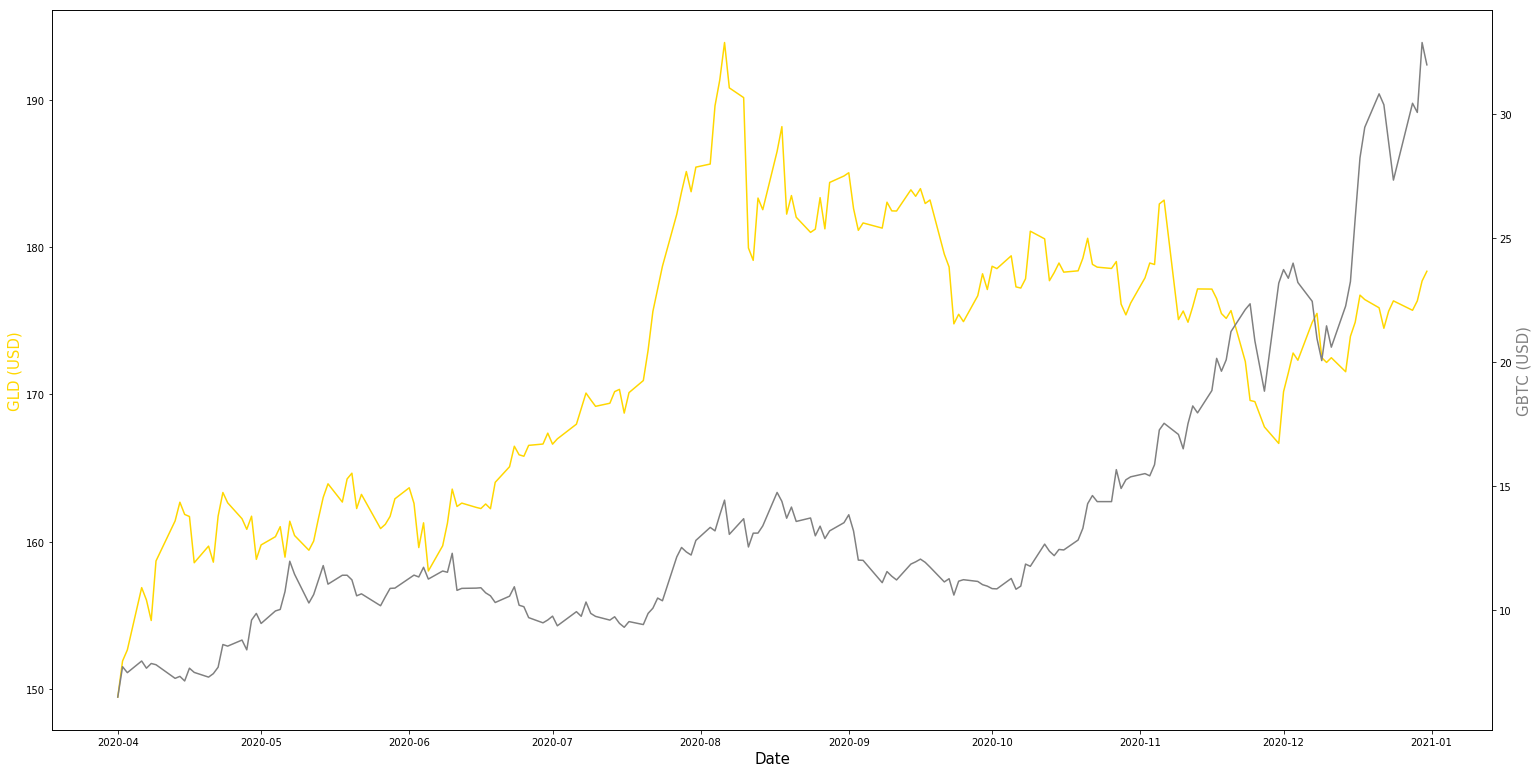

In [ ]:
fig2 = plt.figure()
ax5 = fig2.add_axes([.1,.1,1,1])
ax5.plot(data.index, data.GLD,  color='gold')
ax5.set_xlabel('Date', size = 15)
ax5.set_ylabel('GLD (USD)', size=15, color='gold')
ax5_2 = ax5.twinx()
ax5_2.plot(data.index, data.GBTC, color='gray')
ax5_2.set_ylabel('GBTC (USD)', size=15, color='gray')
plt.show()

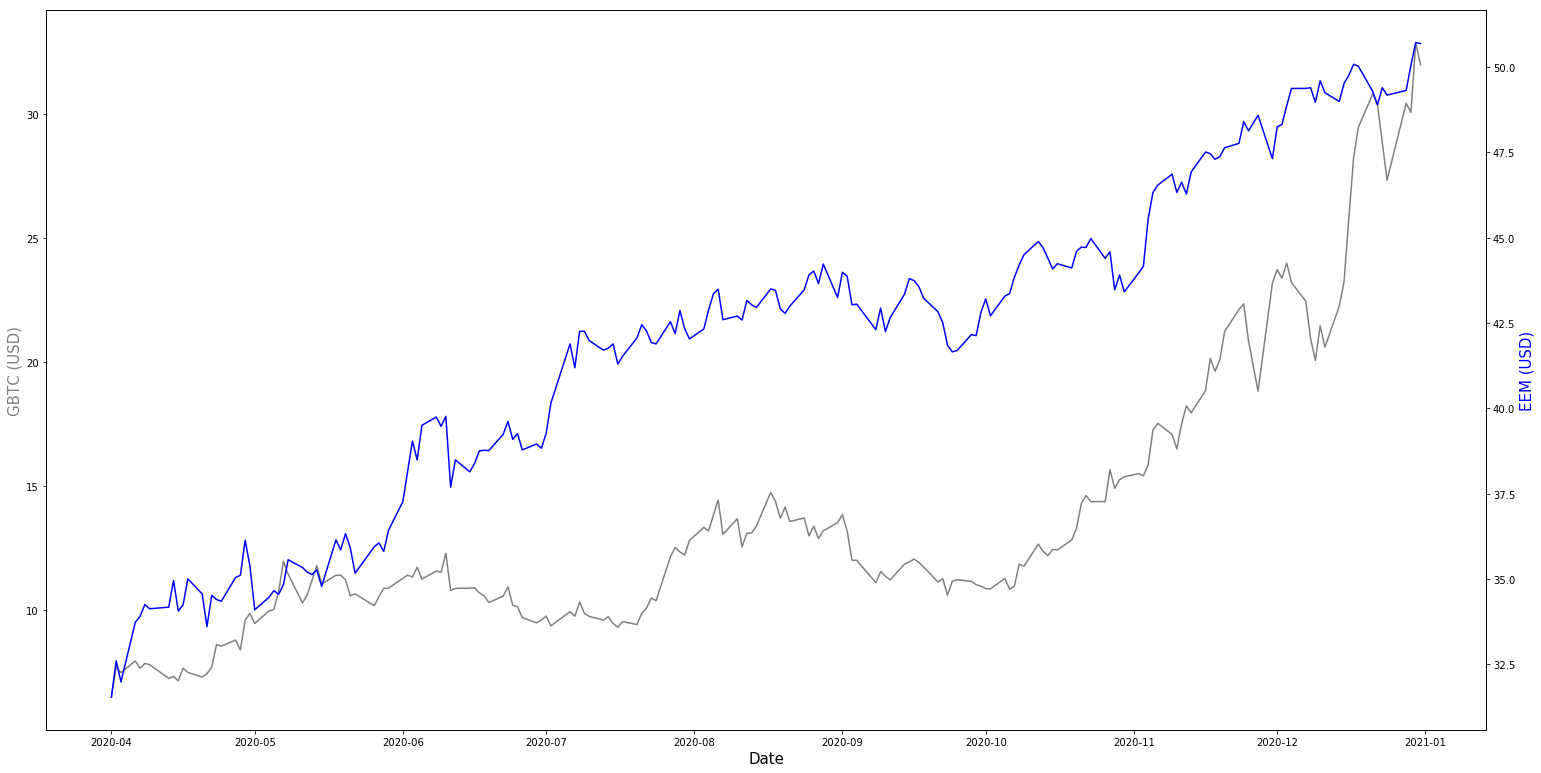

In [ ]:
fig3 = plt.figure()
ax6 = fig3.add_axes([.1,.1,1,1])
ax6.plot(data.index, data.GBTC,  color='gray')
ax6.set_xlabel('Date', size = 15)
ax6.set_ylabel('GBTC (USD)', size=15, color='gray')
ax6_2 = ax6.twinx()
ax6_2.plot(data.index, data.EEM, color='blue')
ax6_2.set_ylabel('EEM (USD)', size=15, color='blue')
plt.show()

### Step 5: Fitting a GARCH Model

We choose to model the gold (GLD) volatility using GARCH models. First, we try estimating the model orders using ACF/PACF:

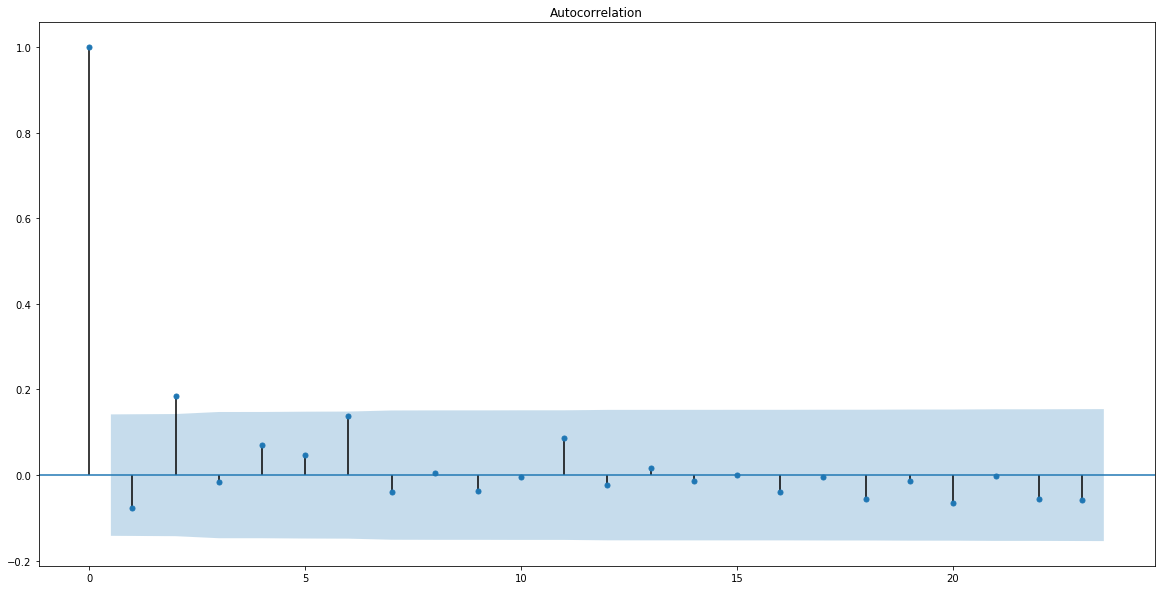

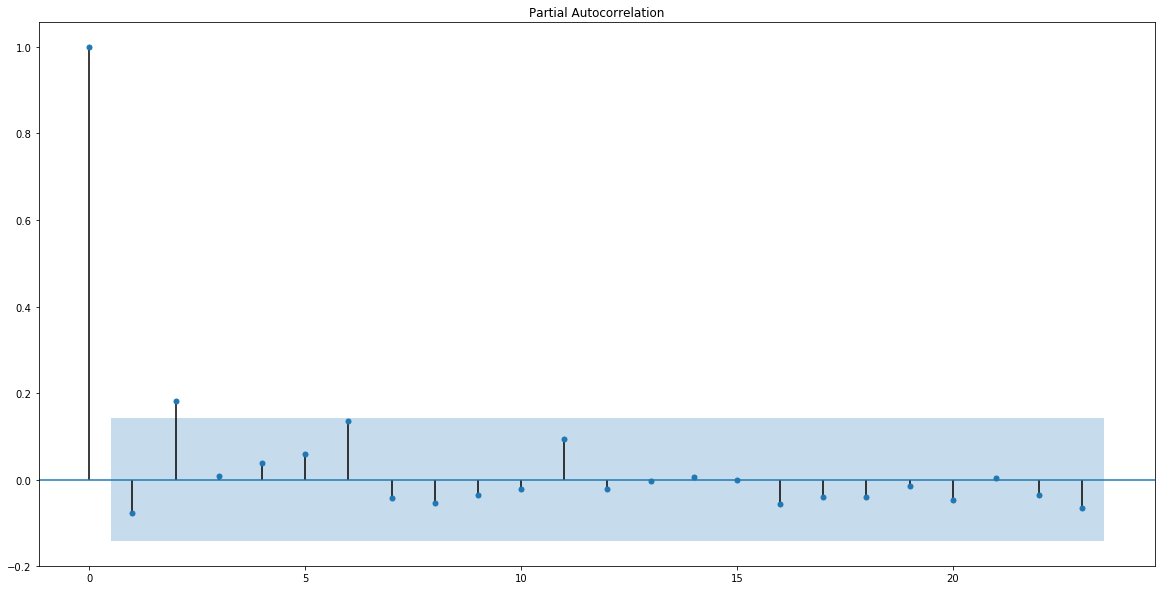

In [ ]:
series = data['GLD_lr']
plot_acf(series**2)
plt.show()
plot_pacf(series**2)
plt.show()

Based on the ACF/PACF plots, we see minimal lagged correlations. So, we choose GARCH(1,1) models.

#### Q2 modeling:

In [ ]:
series_Q2 = data_Q2['GLD_lr']
model_Q2 = arch_model(series_Q2, p=1, q=1)
model_Q2.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.625074722029907e+16
Iteration:      2,   Func. Count:     17,   Neg. LLF: 171433072.5452006
Iteration:      3,   Func. Count:     29,   Neg. LLF: -204.03211774378636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.03211831241384
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                204.032
Distribution:                  Normal   AIC:                          -400.064
Method:            Maximum Likelihood   BIC:                          -391.429
                                        No. Observations:                   64
Date:                Fri, Apr 15 2022   Df Residuals:                       63
Time:                        16:34:59   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2818e-03  3.333e-06    384.567      0.000 [1.275e-03,1.288e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0694e-06  2.138e-10   9678.871      0.000 [2.069e-06,2.070e-06]
alpha[1]       0.1000  8.662e-02      1.154      0.248  [-6.978e-02,  0.270]
beta[1]        0.8800  7.112e-02     12.374  3.623e-35     [  0.741,  1.019]
============================================================================

Covariance estimator: robust
"""

Based on the Q2 results:
$$\omega = 2.07(10^{-6}), \alpha = 0,  \beta = 0.88$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.000017245$ 

#### Q3 modeling:

In [ ]:
series_Q3 = data_Q3['GLD_lr']
model_Q3 = arch_model(series_Q3, p=1, q=1)
model_Q3.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2142554833.4063864
Iteration:      2,   Func. Count:     17,   Neg. LLF: 26111.52911658316
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1054430.3795238454
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1735.6708518504856
Iteration:      5,   Func. Count:     46,   Neg. LLF: 3557263937.3705463
Iteration:      6,   Func. Count:     57,   Neg. LLF: 374572.4027172379
Optimization terminated successfully    (Exit mode 0)
            Current function value: -194.87749877732375
            Iterations: 7
            Function evaluations: 63
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                194.877
Distribution:                  Normal   AIC:                          -381.755
Method:            Maximum Likelihood   BIC:                          -373.057
                                        No. Observations:                   65
Date:                Fri, Apr 15 2022   Df Residuals:                       64
Time:                        16:35:02   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.3700e-04  1.650e-03      0.507      0.612 [-2.397e-03,4.071e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5609e-05  5.169e-11  3.020e+05      0.000 [1.561e-05,1.561e-05]
alpha[1]       0.2000      0.131      1.525      0.127  [-5.703e-02,  0.457]
beta[1]        0.7000      0.109      6.446  1.147e-10     [  0.487,  0.913]
============================================================================

Covariance estimator: robust
"""

Based on the Q3 results:
$$\omega = 1.56(10^{-5}), \alpha = 0,  \beta = 0.70$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.00005203$

#### Q4 modeling:

In [ ]:
series_Q4 = data_Q4['GLD_lr']
model_Q4 = arch_model(series_Q4, p=1, q=1)
model_Q4.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5558931.014819954
Iteration:      2,   Func. Count:     17,   Neg. LLF: -57.4741738904573
Iteration:      3,   Func. Count:     25,   Neg. LLF: -13.14235989478264
Iteration:      4,   Func. Count:     33,   Neg. LLF: -202.43145463622955
Iteration:      5,   Func. Count:     38,   Neg. LLF: -202.42465867078596
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.4314566093114
            Iterations: 5
            Function evaluations: 40
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                202.431
Distribution:                  Normal   AIC:                          -396.863
Method:            Maximum Likelihood   BIC:                          -388.227
                                        No. Observations:                   64
Date:                Fri, Apr 15 2022   Df Residuals:                       63
Time:                        16:35:04   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.9737e-04  1.268e-03      0.156      0.876 [-2.289e-03,2.683e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0532e-04  4.149e-05      2.539  1.113e-02  [2.401e-05,1.866e-04]
alpha[1]   5.2748e-09  2.519e-02  2.094e-07      1.000 [-4.938e-02,4.938e-02]
beta[1]        0.0000      0.244      0.000      1.000      [ -0.478,  0.478]
=============================================================================

Covariance estimator: robust
"""

Based on the Q4 results:
$$\omega = 1.05(10^{-4}), \alpha = 0,  \beta = 0$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.00010532$

### Step 6: Assessing Stationarity

For the three time_series during Q2, we use Augmented Dickey-Fuller (ADF) test to check the stationarity. ADF is in fact for testing the existance of the unit root that is the null hypothesis of the test. So, if we manage to reject the null hypothesis using ADF, we can then consider the alternative hypothesis which is stationarity of the time-series.

#### GLD:

In [ ]:
series = data_Q2['GLD_lr']
p_value = adfuller(series)[1]
print(f'the ADF p_value for GLD in Q1 is: {p_value}')

the ADF p_value for GLD in Q1 is: 3.3707489802171355e-14


#### EEM:

In [ ]:
series = data_Q2['EEM_lr']
p_value = adfuller(series)[1]
print(f'the ADF p_value for GLD in Q1 is: {p_value}')

the ADF p_value for GLD in Q1 is: 5.918877464285016e-21


#### GBTC:

In [ ]:
series = data_Q2['GBTC_lr']
p_value = adfuller(series)[1]
print(f'the ADF p_value for GLD in Q1 is: {p_value}')

the ADF p_value for GLD in Q1 is: 2.8592549901009657e-18


Based on the results above, all the three time-series are stationary during Q2 of 2020.

### Step 7: Modelling Cointegration

### Step 8: Correlation vs Cointegration